In [9]:
import numpy as np
import pandas as pd
import nltk
import requests

nltk.download('punkt')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /Users/mme/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/mme/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train_url = 'https://github.com/Franck-Dernoncourt/pubmed-rct/raw/master/PubMed_20k_RCT/train.txt?raw=true'
val_url = 'https://github.com/Franck-Dernoncourt/pubmed-rct/raw/master/PubMed_20k_RCT/dev.txt?raw=true'
test_url = 'https://github.com/Franck-Dernoncourt/pubmed-rct/raw/master/PubMed_20k_RCT/test.txt?raw=true'

train_file = '../data/pubmed20k/train.txt'
val_file = '../data/pubmed20k/dev.txt'
test_file = '../data/pubmed20k/test.txt'

In [17]:
def read_pubmed_rct(url):

    labels = []
    sentences = []
    
    with requests.get(url) as r:
        for line in r.iter_lines():
            fields = line.decode('utf-8').strip().split('\t')
            if len(fields) == 2:
                labels.append(fields[0])
                sentences.append(fields[1])
                
    return sentences, labels

s_train, l_train = read_pubmed_rct(train_url)
s_val, l_val = read_pubmed_rct(val_url)
s_test, l_test = read_pubmed_rct(test_url)

len(s_train), len(s_val), len(s_test)

(180040, 30212, 30135)

In [18]:
print('The labels are:')
print(np.unique(l_train))

The labels are:
['BACKGROUND' 'CONCLUSIONS' 'METHODS' 'OBJECTIVE' 'RESULTS']


In [19]:
def tokenize(sentence):
    return [w.lower() for w in word_tokenize(sentence) if ((not w in stop_words) and w.isalpha())]

tokens_train = [tokenize(s) for s in s_train]
tokens_val = [tokenize(s) for s in s_val]
tokens_test = [tokenize(s) for s in s_test]

In [22]:
min_word_count = 100

words, counts = np.unique([word for tokens in tokens_train for word in tokens], return_counts=True)

vocab = words[counts > min_word_count]
vocab_dict = {word:idx for idx, word in enumerate(vocab)}

print('Obtained %i vocabulary words. Here are the first 100:\n' % len(vocab))
print(vocab[:100])
print('\nAnd the last 100:\n')
print(vocab[-100:])

Obtained 3000 vocabulary words. Here are the first 100:

['a' 'aa' 'abdominal' 'ability' 'ablation' 'able' 'abnormal'
 'abnormalities' 'absence' 'absolute' 'absorption' 'abstinence' 'abuse'
 'academic' 'acceptability' 'acceptable' 'acceptance' 'accepted' 'access'
 'accompanied' 'according' 'account' 'accuracy' 'accurate' 'acetaminophen'
 'acetate' 'achieve' 'achieved' 'achievement' 'achieving' 'acid' 'acids'
 'acl' 'acquired' 'acquisition' 'across' 'acs' 'act' 'action' 'activation'
 'active' 'activities' 'activity' 'actual' 'acuity' 'acupoint' 'acupoints'
 'acupuncture' 'acute' 'ad' 'adalimumab' 'adapted' 'adaptive' 'added'
 'adding' 'addition' 'additional' 'additionally' 'address' 'adequate'
 'adhd' 'adherence' 'adhesion' 'adiponectin' 'adjunct' 'adjunctive'
 'adjusted' 'adjusting' 'adjustment' 'adjuvant' 'administered'
 'administration' 'admission' 'admitted' 'adolescent' 'adolescents'
 'adopted' 'adult' 'adults' 'advanced' 'advantage' 'advantages' 'adverse'
 'advice' 'ae' 'aerobic' 

In [23]:
def word_counts(tokens_list, vocab_dict):   
    vocab_words = vocab_dict.keys()
    counts = np.zeros((len(tokens_list), len(vocab_words)))
    for idx, tokens in enumerate(tokens_list):
        for token in tokens:
            if token in vocab_words:
                counts[idx, vocab_dict[token]] += 1
    return counts

counts_train = word_counts(tokens_train, vocab_dict)
counts_val = word_counts(tokens_val, vocab_dict)
counts_test = word_counts(tokens_test, vocab_dict)

In [25]:
def term_freq(counts):
    row_totals = np.sum(counts, axis=1) + 1
    assert np.amin(row_totals) > 0
    return counts / row_totals[:, np.newaxis]

def document_freq(counts):
    col_totals = np.sum((counts > 0).astype('int'), axis=0) + 1
    assert np.amin(col_totals) > 0
    return col_totals[np.newaxis, :] / (len(counts) + 1)

x_train = term_freq(counts_train) / document_freq(counts_train)
x_val = term_freq(counts_val) / document_freq(counts_train)
x_test = term_freq(counts_test) / document_freq(counts_train)

In [26]:
label_dict = {'OBJECTIVE': 0, 'BACKGROUND': 1, 'METHODS': 2, 'RESULTS': 5, 'CONCLUSIONS': 4}

def labels_to_indices(labels):
    return np.array([label_dict[l] for l in labels])

y_train = labels_to_indices(l_train)
y_val = labels_to_indices(l_val)
y_test = labels_to_indices(l_test)

In [27]:
pd.value_counts(l_val, normalize=True)

METHODS        0.329803
RESULTS        0.325731
CONCLUSIONS    0.151662
BACKGROUND     0.114160
OBJECTIVE      0.078644
dtype: float64

In [28]:
from sklearn.linear_model import LogisticRegression

lrc = LogisticRegression()
lrc.fit(x_train, y_train)
predictions = lrc.predict(x_val)
accuracy = sum(predictions == y_val) / len(predictions)

print(accuracy)

0.7724414140076791


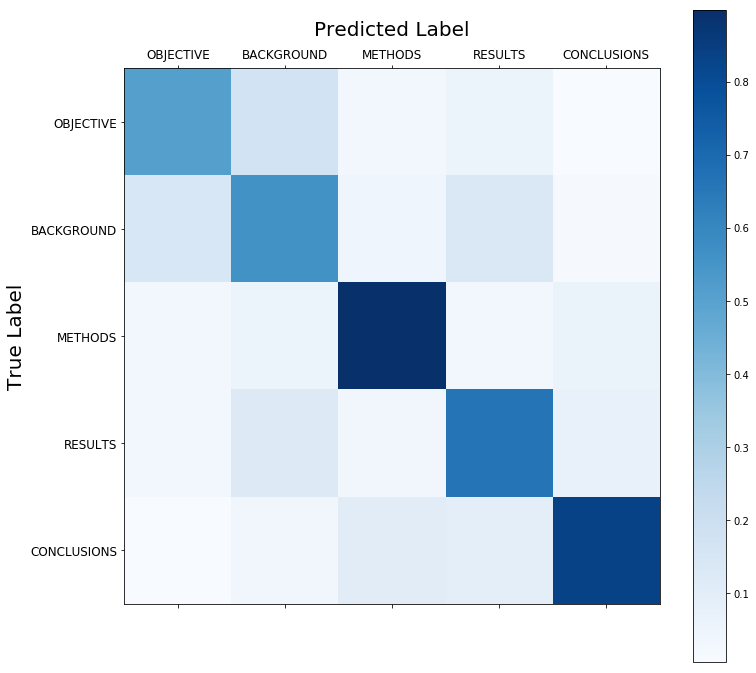

In [31]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(predicted_labels, true_labels, normalize=True):
    cm = confusion_matrix(true_labels, predicted_labels)
    if normalize == True:
        cm = cm / np.sum(cm, axis=1)
    fig, ax = plt.subplots(figsize=(12, 12))
    im = ax.matshow(cm, cmap='Blues')
    fig.colorbar(im, ax=ax)
    ax.set_title('Predicted Label', fontsize=20)
    ax.set_xticks(np.arange(5))
    ax.set_xticklabels(label_dict.keys(), fontsize=12)
    ax.set_yticks(np.arange(5))
    ax.set_yticklabels(label_dict.keys(), fontsize=12)
    ax.set_ylabel('True Label', fontsize=20)
    plt.show()
    
plot_confusion_matrix(predictions, y_val)

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(300,), early_stopping=True)
mlp.fit(x_train, y_train)
predictions = mlp.predict(x_val)
accuracy = sum(predictions == y_val) / len(predictions)

print(accuracy)

In [50]:
glove_file = '../data/glove/glove.6B.300d.txt'
glove_url = ''

def loadGloveModel(gloveFile):
    print("Loading Glove Model")
    f = open(gloveFile,'r')
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding / np.linalg.norm(embedding, ord=2)
    print("Done.",len(model)," words loaded!")
    return model

glove_dict = loadGloveModel(glove_file)

Loading Glove Model
Done. 400000  words loaded!


In [52]:
'myocardium' in glove_dict.keys()

True

In [55]:
glove_vocab = glove_dict.keys()

def swem(t_list):
    arr = []
    for t in t_list:
        if t in glove_vocab:
            arr.append(glove_dict[t])
    if len(arr) == 0:
        return np.zeros(600)
    elif len(arr) == 1:
        return np.concatenate(arr + arr)
    else:
        arr = np.stack(arr)
        swem_max = np.amax(arr, axis=0)
        swem_avg = np.mean(arr, axis=0)
        return np.concatenate([swem_max, swem_avg])

x_train_swem = np.stack([swem(tokens) for tokens in tokens_train])
x_val_swem = np.stack([swem(tokens) for tokens in tokens_val])
x_test_swem = np.stack([swem(tokens) for tokens in tokens_test])

In [56]:
np.shape(x_train_swem), np.shape(x_val_swem), np.shape(x_test_swem)

((180040, 600), (30212, 600), (30135, 600))

In [57]:
from sklearn.linear_model import LogisticRegression

lrc = LogisticRegression()
lrc.fit(x_train_swem, y_train)
predictions = lrc.predict(x_val_swem)
accuracy = sum(predictions == y_val) / len(predictions)

print(accuracy)

0.7075996292863763


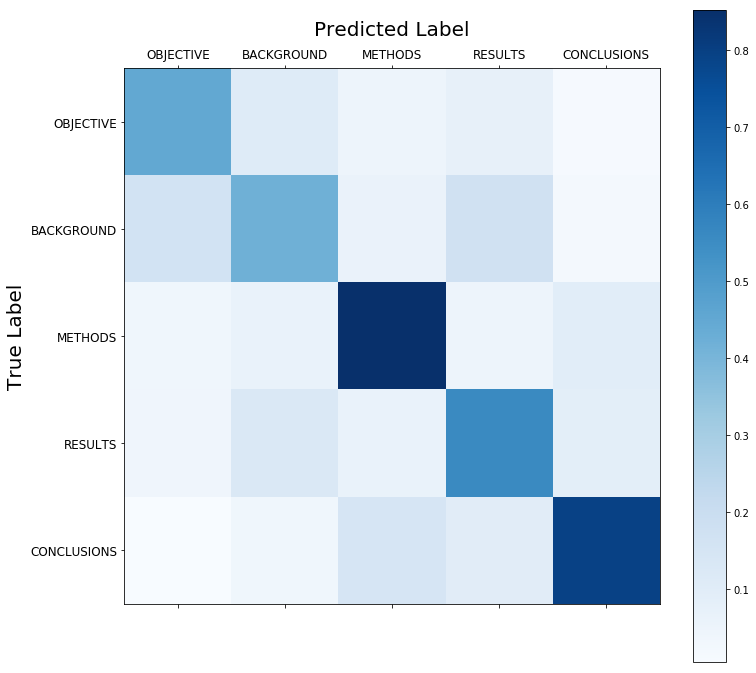

In [58]:
plot_confusion_matrix(predictions, y_val)

In [60]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(300,), early_stopping=True)
mlp.fit(x_train_swem, y_train)
predictions = mlp.predict(x_val_swem)
accuracy = sum(predictions == y_val) / len(predictions)

print(accuracy)

0.7643320534886799
